In [29]:
# Import statements
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments, AdamW, BertConfig, get_linear_schedule_with_warmup
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, TensorDataset, random_split, DataLoader, RandomSampler, SequentialSampler
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import random
import time
import datetime
from tqdm import tqdm
import os
import wget
import zipfile
from pathlib import Path

In [30]:
# A function for the calculation of accuracy
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

# A function to convert times to a readable format
def format_time(elapsed):
    return str(datetime.timedelta(seconds=int(round((elapsed)))))

In [31]:
# Set device to whatever device is available
if torch.cuda.is_available():
    device = torch.device('cuda')
    print('Using GPU')
else:
    device = torch.device('cpu')
    print('Using CPU')

Using GPU


In [32]:
# Load our Financial Phrasebank dataset from the huggingface page
url = 'https://huggingface.co/datasets/takala/financial_phrasebank/resolve/main/data/FinancialPhraseBank-v1.0.zip?download=true'

if not os.path.exists('FinancialPhraseBank-v1.0.zip'):
    print('Downloading Financial Phrasebank dataset...')
    wget.download(url, 'FinancialPhraseBank-v1.0.zip')

# Unzip the dataset
if not os.path.exists('FinancialPhraseBank-v1.0'):
    print('Unzipping Financial Phrasebank dataset...')
    with zipfile.ZipFile('FinancialPhraseBank-v1.0.zip', 'r') as zip_ref:
        zip_ref.extractall('FinancialPhraseBank-v1.0')

In [33]:
# Read in the txt file (the separators used are '\@')
data = pd.read_csv('FinancialPhraseBank-v1.0/FinancialPhraseBank-v1.0/Sentences_75Agree.txt', sep = '\@', header=None, names=['text', 'sentiment'], encoding='ISO-8859-1')

# Report the number of sentences.
print('Number of training sentences: {:,}\n'.format(data.shape[0]))

# Display 10 random rows from the data.
data.sample(10)

Number of training sentences: 3,453



<ipython-input-33-079a8162ced4>:2: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  data = pd.read_csv('FinancialPhraseBank-v1.0/FinancialPhraseBank-v1.0/Sentences_75Agree.txt', sep = '\@', header=None, names=['text', 'sentiment'], encoding='ISO-8859-1')


,text,sentiment
511,Turnover surged to EUR61 .8 m from EUR47 .6 m ...,positive
51,In June it sold a 30 percent stake to Nordstje...,neutral
1886,Aspo 's Group structure and business operation...,neutral
765,The device can also be used for theft protecti...,neutral
557,"Of the price , Kesko 's share is 10 mln euro $...",positive
761,The address location is provided to a local co...,neutral
2709,The electricity requirement of networks will g...,neutral
192,"( ADP News ) - Oct 29 , 2008 - Finnish lifting...",positive
1537,"According to Soosalu , particular attention wa...",neutral
693,Strong growth has continued also in China .,positive


In [34]:
# Map the sentiment labels to integers
sentiment_map = {'neutral': 0, 'positive': 1, 'negative': 2}
data['sentiment'] = data.sentiment.map(sentiment_map)

X = data.text.values
y = data.sentiment.values

# Tokenize our data
print('Tokenizing data...')
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case = True)

# Print out a sentence and its tokenized form
print('Original: ', X[0])
print('Tokenized: ', tokenizer.tokenize(X[0]))
print('Token IDs: ', tokenizer.convert_tokens_to_ids(tokenizer.tokenize(X[0])))

Tokenizing data...
Original:  According to Gran , the company has no plans to move all production to Russia , although that is where the company is growing .
Tokenized:  ['according', 'to', 'gran', ',', 'the', 'company', 'has', 'no', 'plans', 'to', 'move', 'all', 'production', 'to', 'russia', ',', 'although', 'that', 'is', 'where', 'the', 'company', 'is', 'growing', '.']
Token IDs:  [2429, 2000, 12604, 1010, 1996, 2194, 2038, 2053, 3488, 2000, 2693, 2035, 2537, 2000, 3607, 1010, 2348, 2008, 2003, 2073, 1996, 2194, 2003, 3652, 1012]


In [35]:
# Initialize our max sentence length
max_len = 0
for text in X:
    # Tokenize text and add special tokens
    input_ids = tokenizer.encode(text, add_special_tokens=True)
    # Update max sentence length
    max_len = max(max_len, len(input_ids))

print('Max sentence length: ', max_len)

Max sentence length:  150


In [36]:
# Tokenize all of the sentences and map the tokens to their word IDs
input_ids = []
attention_masks = []

for text in X:
    encoded_dict = tokenizer.encode_plus(
                        text,                      # Sentence to encode.
                        add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                        max_length = 175,           # Pad & truncate all sentences.
                        pad_to_max_length = True,
                        return_attention_mask = True,   # Construct attention masks.
                        return_tensors = 'pt',     # Return pytorch tensors.
                   )

    # Add the encoded sentence to the list.
    input_ids.append(encoded_dict['input_ids'])

    # And its attention mask (simply differentiates padding from non-padding).
    attention_masks.append(encoded_dict['attention_mask'])

# Convert lists into tensors
input_ids = torch.cat(input_ids, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)
y = torch.tensor(y)
print('Original: ', X[0])
print('Token IDs: ', input_ids[0])

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2760: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


Original:  According to Gran , the company has no plans to move all production to Russia , although that is where the company is growing .
Token IDs:  tensor([  101,  2429,  2000, 12604,  1010,  1996,  2194,  2038,  2053,  3488,
         2000,  2693,  2035,  2537,  2000,  3607,  1010,  2348,  2008,  2003,
         2073,  1996,  2194,  2003,  3652,  1012,   102,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0

In [37]:
# Split our data
dataset = TensorDataset(input_ids, attention_masks, y)
# Use 80% for training and 20% for validation.
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

In [38]:
# Initialize our data loaders for train and validation sets
batch_size = 32

# RandomSampler samples elements randomly
train_loader = DataLoader(
            train_dataset,
            sampler = RandomSampler(train_dataset),
            batch_size = batch_size
)

# SequentialSampler samples elements in order
val_loader = DataLoader(
            val_dataset,
            sampler = SequentialSampler(val_dataset),
            batch_size = batch_size
)

In [39]:
# Define our model from the pretrained BERT model
model = BertForSequenceClassification.from_pretrained('bert-base-uncased',
                                                      num_labels=3,
                                                      output_attentions = False,
                                                      output_hidden_states = False).to(device)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [40]:
# We use the AdamW optimizer here
optimizer = optim.AdamW(model.parameters(),
                        lr=2e-5,
                        eps = 1e-8)

In [41]:
# Define variables for our traing loop
epochs = 3
total_step = len(train_loader) * epochs
scheduler = get_linear_schedule_with_warmup(optimizer,
                                            num_warmup_steps = 0,
                                            num_training_steps = total_step)

random_seed = 42
random.seed(random_seed)
np.random.seed(random_seed)
torch.manual_seed(random_seed)
torch.cuda.manual_seed_all(random_seed)

# We want to keep track of our training_stats throughout each epoch
training_stats = []
total_t0 = time.time()

# Training loop
for epoch in range(epochs):
    print(f'Epoch {epoch + 1} of {epochs}')
    t0 = time.time()
    model.train()
    train_loss = 0.0
    for batch in tqdm(train_loader, desc='Epoch {:1d}'.format(epoch), leave=False, disable=False):
        batch = tuple(b.to(device) for b in batch)
        inputs = {'input_ids': batch[0], 'attention_mask': batch[1], 'labels': batch[2]}
        inputs = {key: val.to(device) for key, val in inputs.items()}
        optimizer.zero_grad()
        outputs = model(**inputs)
        loss = outputs.loss
        loss.backward()
        optimizer.step()
        scheduler.step()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        train_loss += loss.item()

    train_loss /= len(train_loader)
    training_time = format_time(time.time() - t0)
    print(f'Epoch {epoch + 1}, Train Loss: {train_loss:.4f}')
    print(f'Training epoch took: {training_time}')

    # Validation
    print('Validation...')
    t0 = time.time()
    model.eval()
    total_val_accuracy = 0.0
    val_loss = 0.0
    with torch.no_grad():
        for batch in val_loader:
            b_input_ids = batch[0].to(device)
            b_input_mask = batch[1].to(device)
            b_labels = batch[2].to(device)
            outputs = model(b_input_ids,
                            token_type_ids=None,
                            attention_mask=b_input_mask,
                            labels=b_labels)
            loss = outputs.loss
            val_loss += loss.item()
            logits = outputs.logits.detach().cpu().numpy()
            label_ids = b_labels.to('cpu').numpy()
            total_val_accuracy += flat_accuracy(logits, label_ids)
    val_loss /= len(val_loader)
    avg_val_accuracy = total_val_accuracy / len(val_loader)
    validation_time = format_time(time.time() - t0)
    print(f'Epoch {epoch + 1}, Val Loss: {val_loss:.4f}')
    print(f'Validation took: {validation_time}')
    print(f'Validation Accuracy: {avg_val_accuracy:.4f}')
    training_stats.append(
        {
            'epoch': epoch + 1,
            'Training Loss': train_loss,
            'Valid. Loss': val_loss,
            'Valid. Accur.': avg_val_accuracy,
            'Training Time': training_time,
            'Validation Time': validation_time
        }
    )

print('Done training')
print(f'Training took: {format_time(time.time() - total_t0)}')

Epoch 1 of 3


Epoch 1, Train Loss: 0.6381
Training epoch took: 0:01:13
Validation...
Epoch 1, Val Loss: 0.3633
Validation took: 0:00:07
Validation Accuracy: 0.8938
Epoch 2 of 3


Epoch 2, Train Loss: 0.2441
Training epoch took: 0:01:16
Validation...
Epoch 2, Val Loss: 0.2085
Validation took: 0:00:07
Validation Accuracy: 0.9308
Epoch 3 of 3


Epoch 3, Train Loss: 0.1274
Training epoch took: 0:01:18
Validation...
Epoch 3, Val Loss: 0.1883
Validation took: 0:00:07
Validation Accuracy: 0.9346
Done training
Training took: 0:04:08


In [42]:
df_stats = pd.DataFrame(data=training_stats)
df_stats = df_stats.set_index('epoch')
df_stats

,Training Loss,Valid. Loss,Valid. Accur.,Training Time,Validation Time
epoch,,,,,
1,0.638084,0.363284,0.893840,0:01:13,0:00:07
2,0.244100,0.208537,0.930772,0:01:16,0:00:07
3,0.127400,0.188344,0.934584,0:01:18,0:00:07


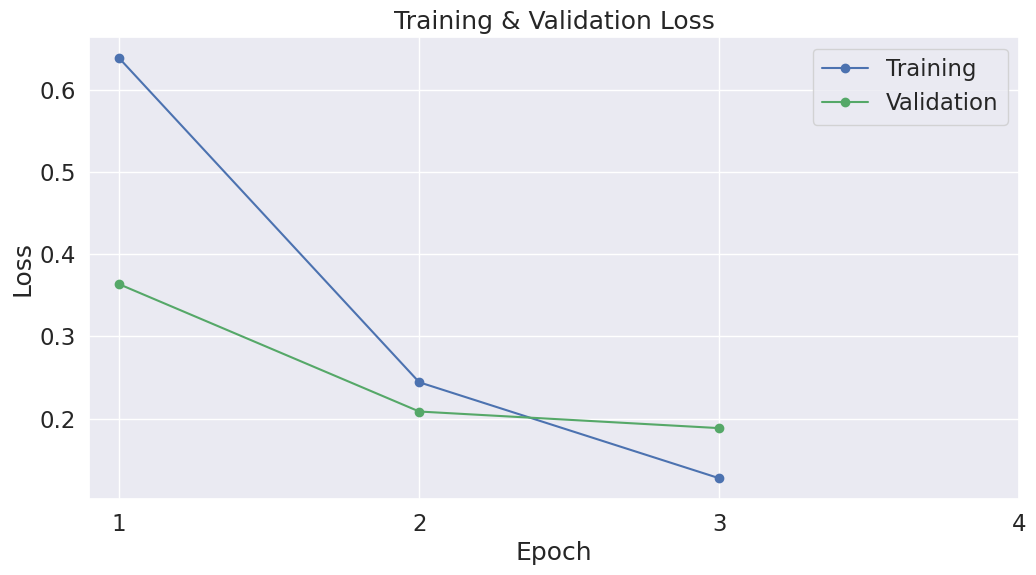

In [43]:
# Plot the Training & Validation Loss
sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

# Plot the learning curve.
plt.plot(df_stats['Training Loss'], 'b-o', label="Training")
plt.plot(df_stats['Valid. Loss'], 'g-o', label="Validation")

# Label the plot.
plt.title("Training & Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.xticks([1, 2, 3, 4])

plt.show()

In [45]:
# Save our model
# 1. Directory
OUTPUT_DIR = './models/'
if not os.path.exists(OUTPUT_DIR):
  os.makedirs(OUTPUT_DIR)

# 2. Create model save path
MODEL_NAME = "Finetuned_BERT.model.pth"
MODEL_SAVE_PATH = OUTPUT_DIR + MODEL_NAME

# 3. Save model state dict
torch.save(obj=model.state_dict(),
           f=MODEL_SAVE_PATH)